In [56]:
%load_ext autoreload
%autoreload 2

from Shared.shared import *
from Shared.specific_CNB_sim import *

sim_name = f"neutrino_halo"
sim_folder = f"sim_output/{sim_name}"
fig_folder = f"figures_local/{sim_name}"
Cl_folder = f"Shared/Cls"
nu_m_range = jnp.load(f"{sim_folder}/neutrino_massrange_eV.npy")
nu_m_picks = jnp.array([0.01, 0.05, 0.1, 0.2, 0.3])*Params.eV
simdata = SimData(sim_folder)

z_int_steps = jnp.load(f"{sim_folder}/z_int_steps.npy")
s_int_steps = jnp.load(f"{sim_folder}/s_int_steps.npy")

#! Broken halos: either snapshot info missing or anomalous number densities
exclude_nums = jnp.array([
    20,
    # 21,
    24,
    25,
])
halo_nums = [x for x in range(1, 31) if x not in exclude_nums]


# Fermi-Dirac distribution assumption
# note: total densities are computed for length 50 mass range
pix_dens_FD = jnp.load(f"{sim_folder}/pixel_densities.npy")
tot_dens_FD = jnp.load(f"{sim_folder}/total_densities.npy")

print(pix_dens_FD.shape)
print(tot_dens_FD.shape)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(1, 300, 5, 768)
(1, 300, 50)


## Pre-sim neutrino halo grid creation

### Functions

In [44]:
from scipy.spatial import cKDTree

def reduce_cells(cell_centers, target_n, k_neighbors=10):
    """
    Reduce the number of cells while preserving regions of higher cell density.
    
    Parameters:
    cell_centers (np.array): Array of shape (N, 3) containing cell center coordinates.
    target_n (int): Target number of cells after reduction.
    k_neighbors (int): Number of neighbors to consider for density estimation.
    
    Returns:
    np.array: Reduced array of cell centers with shape (target_n, 3).
    """
    N = len(cell_centers)
    if target_n >= N:
        return cell_centers[:target_n]  # Return all cells if target_n is greater or equal
    
    # Create a KD-tree for efficient nearest neighbor search
    tree = cKDTree(cell_centers)
    
    # Estimate local density for each cell
    distances, _ = tree.query(cell_centers, k=k_neighbors)
    local_density = 1 / np.mean(distances, axis=1)
    
    # Normalize densities to use as weights
    weights = local_density / np.sum(local_density)
    
    # Use weights to select cells
    np.random.seed(0)
    selected_indices = np.random.choice(N, size=target_n, replace=False, p=weights)
    
    return cell_centers[selected_indices]


def fibonacci_sphere(samples, radius=1):
    """Generate points on a sphere using the Fibonacci spiral method."""
    points = []
    phi = np.pi * (3. - np.sqrt(5.))  # golden angle in radians
    for i in range(samples):
        y = 1 - (i / float(samples - 1)) * 2  # y goes from 1 to -1
        radius_at_y = np.sqrt(1 - y * y)  # radius at y
        theta = phi * i  # golden angle increment
        x = np.cos(theta) * radius_at_y
        z = np.sin(theta) * radius_at_y
        points.append((x * radius, y * radius, z * radius))
    return np.array(points)


def select_spherical_grid(cell_centers, target_n, n_shells=10):
    """
    Select cells from the original grid to form a spherically symmetric grid.
    
    Parameters:
    cell_centers (np.array): Array of shape (N, 3) containing cell center coordinates.
    target_n (int): Target number of cells in the final grid.
    n_shells (int): Number of spherical shells to use.
    
    Returns:
    np.array: Selected cell centers forming a spherically symmetric grid.
    """
    # Find the center and maximum radius of the original grid
    center = np.mean(cell_centers, axis=0)
    max_radius = np.max(np.linalg.norm(cell_centers - center, axis=1))
    
    # Create KD-Tree for efficient nearest neighbor search
    tree = cKDTree(cell_centers)
    
    selected_cells = []
    cells_per_shell = target_n // n_shells
    
    for i in range(n_shells):
        radius = max_radius * (i + 1) / n_shells
        # Generate points on the sphere for this shell
        sphere_points = fibonacci_sphere(cells_per_shell, radius) + center
        
        # Find the nearest cells to these points
        _, indices = tree.query(sphere_points)
        selected_cells.extend(cell_centers[indices])
    
    # If we haven't reached target_n, add more cells from the last shell
    while len(selected_cells) < target_n:
        extra_points = fibonacci_sphere(target_n - len(selected_cells), max_radius) + center
        _, indices = tree.query(extra_points)
        selected_cells.extend(cell_centers[indices])
    
    return np.array(selected_cells[:target_n])


def plot_grids(cell_centers, reduced_centers):

    # Create the figure and 3D axes
    fig = plt.figure(figsize=(20, 10))

    # Original grid plot
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(cell_centers[:, 0], cell_centers[:, 1], cell_centers[:, 2], 
                c='blue', s=1, alpha=0.5)
    ax1.set_title(f'Original Grid\n{len(cell_centers)} cells')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')

    # Pruned grid plot
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(reduced_centers[:, 0], reduced_centers[:, 1], reduced_centers[:, 2], 
                c='red', s=1, alpha=0.5)
    ax2.set_title(f'Pruned Grid\n{len(reduced_centers)} cells')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')

    # Ensure the same scale for both plots
    x_lim = (min(cell_centers[:, 0].min(), reduced_centers[:, 0].min()),
            max(cell_centers[:, 0].max(), reduced_centers[:, 0].max()))
    y_lim = (min(cell_centers[:, 1].min(), reduced_centers[:, 1].min()),
            max(cell_centers[:, 1].max(), reduced_centers[:, 1].max()))
    z_lim = (min(cell_centers[:, 2].min(), reduced_centers[:, 2].min()),
            max(cell_centers[:, 2].max(), reduced_centers[:, 2].max()))

    ax1.set_xlim(x_lim)
    ax1.set_ylim(y_lim)
    ax1.set_zlim(z_lim)
    ax2.set_xlim(x_lim)
    ax2.set_ylim(y_lim)
    ax2.set_zlim(z_lim)

    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()


def plot_fibonacci_sphere_layer(n_points, radius=1, show_sphere=True, show_lines=True, n_neighbors=5):
    """
    Plot a single layer of points on a sphere using the Fibonacci spiral method,
    with a surface lattice connecting neighboring points.
    
    Parameters:
    n_points (int): Number of points to plot on the sphere.
    radius (float): Radius of the sphere.
    show_lines (bool): If True, show lines connecting neighboring points on the surface.
    n_neighbors (int): Number of nearest neighbors to connect for each point.
    """
    # Generate points
    points = fibonacci_sphere(n_points, radius)
    
    # Create the figure and 3D axes
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the points
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='blue', s=20)
    
    # Plot the connecting lines if requested
    if show_lines:
        # Use KDTree to find nearest neighbors
        tree = cKDTree(points)
        
        # Find k nearest neighbors for each point
        distances, indices = tree.query(points, k=n_neighbors+1)  # +1 because the point itself is included
        
        # Plot lines to neighbors
        for i, neighbors in enumerate(indices):
            for neighbor in neighbors[1:]:  # Skip the first neighbor (which is the point itself)
                ax.plot(*zip(points[i], points[neighbor]), color='red', linewidth=0.5, alpha=0.2)
    
    # Plot the sphere if requested
    if show_sphere:
        u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
        x = radius * np.cos(u) * np.sin(v)
        y = radius * np.sin(u) * np.sin(v)
        z = radius * np.cos(v)
        ax.plot_wireframe(x, y, z, color="g", alpha=0.1)
    
    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Fibonacci Spiral on Sphere\n{n_points} points, radius = {radius}')
    
    # Set aspect ratio to be equal
    ax.set_box_aspect((1,1,1))
    
    # Show the plot
    plt.tight_layout()
    plt.show()



### (OLD) Reduce original grid while keeping DM density pattern

1.2719748118083942 488.4383277344233
2.435646330417246 409.73650069282326


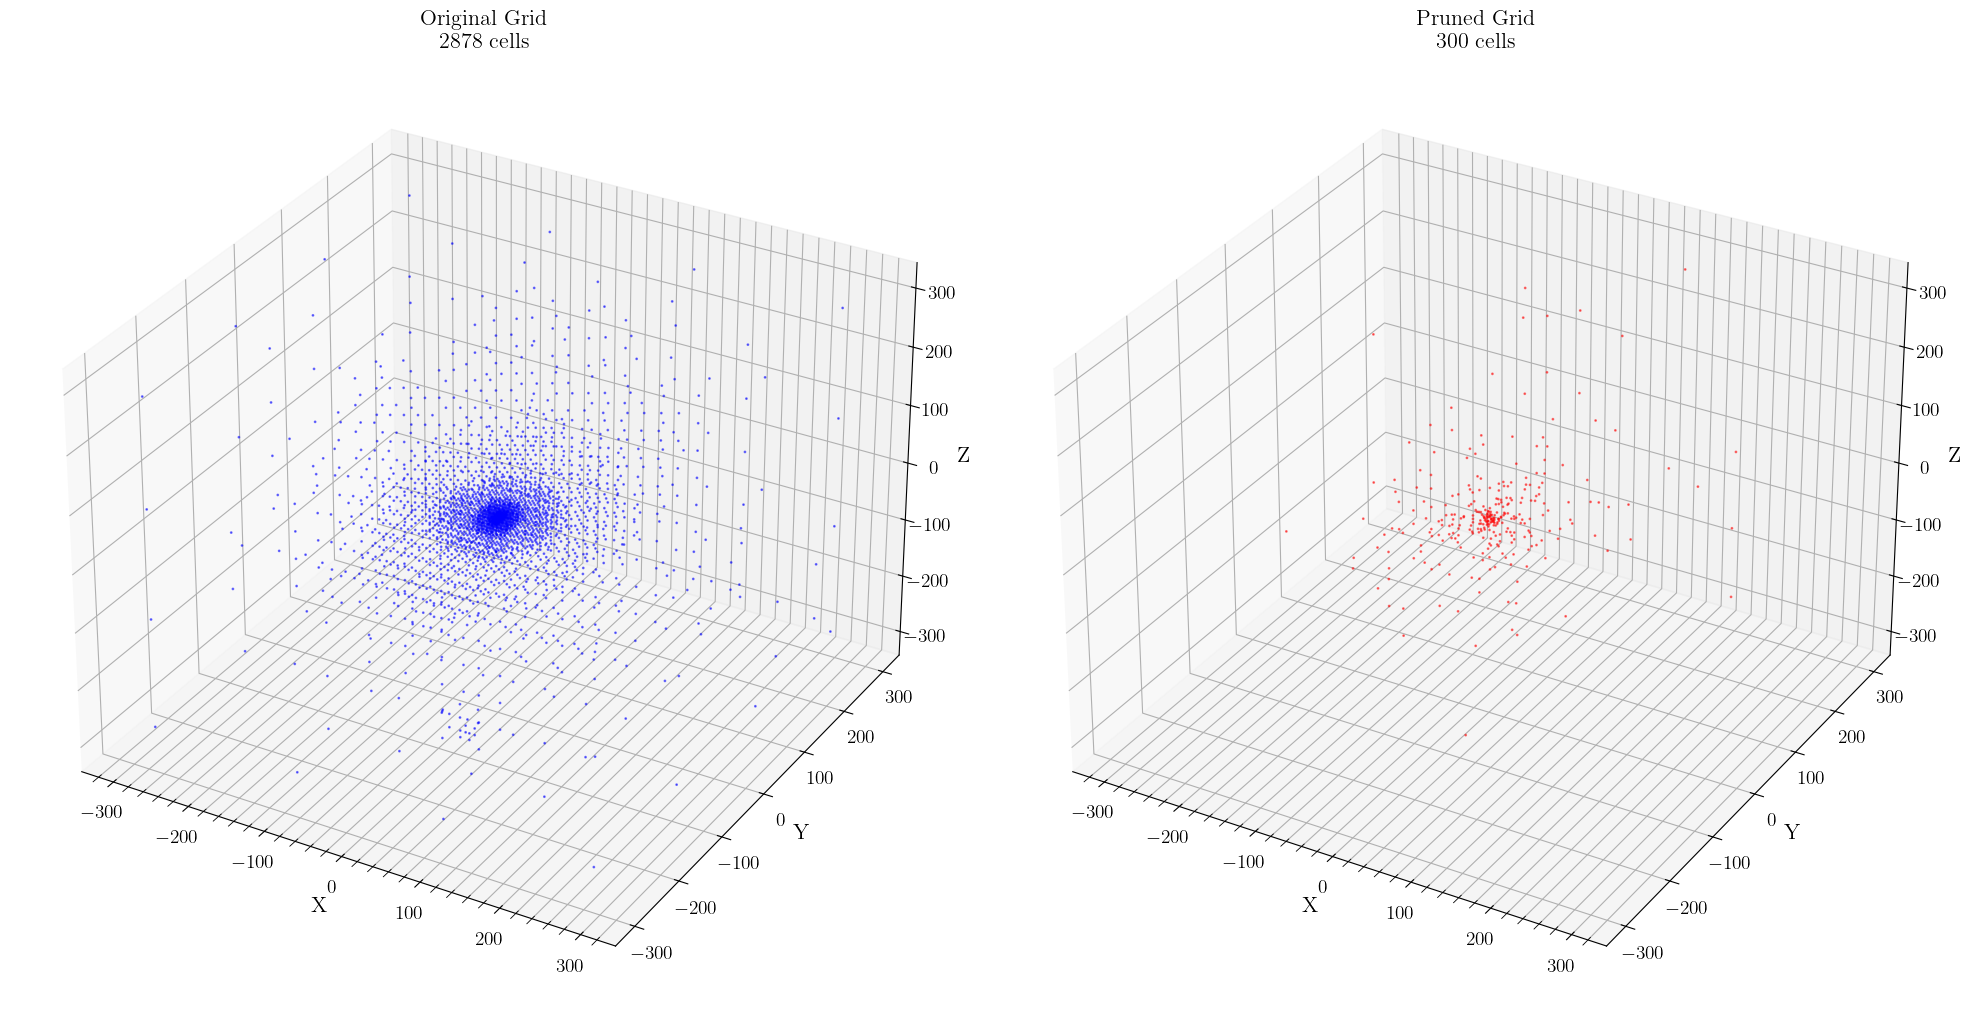

In [48]:
# Cell grid of a halo
cell_grid = jnp.squeeze(jnp.load("Data/halo_grids/fin_grid_origID20_snap_0036.npy"))/Params.kpc
# print(cell_grid.shape)

# Reduce cell count while respecting DM densities
cell_grid_pruned = reduce_cells(cell_grid, target_n=300, k_neighbors=len(cell_grid))
# print(cell_grid_pruned.shape)

# Compute distances of original cells and analyze min/max
cell_distances = jnp.linalg.norm(cell_grid, axis=-1)
# print(cell_distances.sort())
print(cell_distances.min(), cell_distances.max())

cell_distances = jnp.linalg.norm(cell_grid_pruned, axis=-1)
# print(cell_distances.sort())
print(cell_distances.min(), cell_distances.max())

plot_grids(cell_grid, cell_grid_pruned)

### Show 1-layer of Fibonacci sphere method

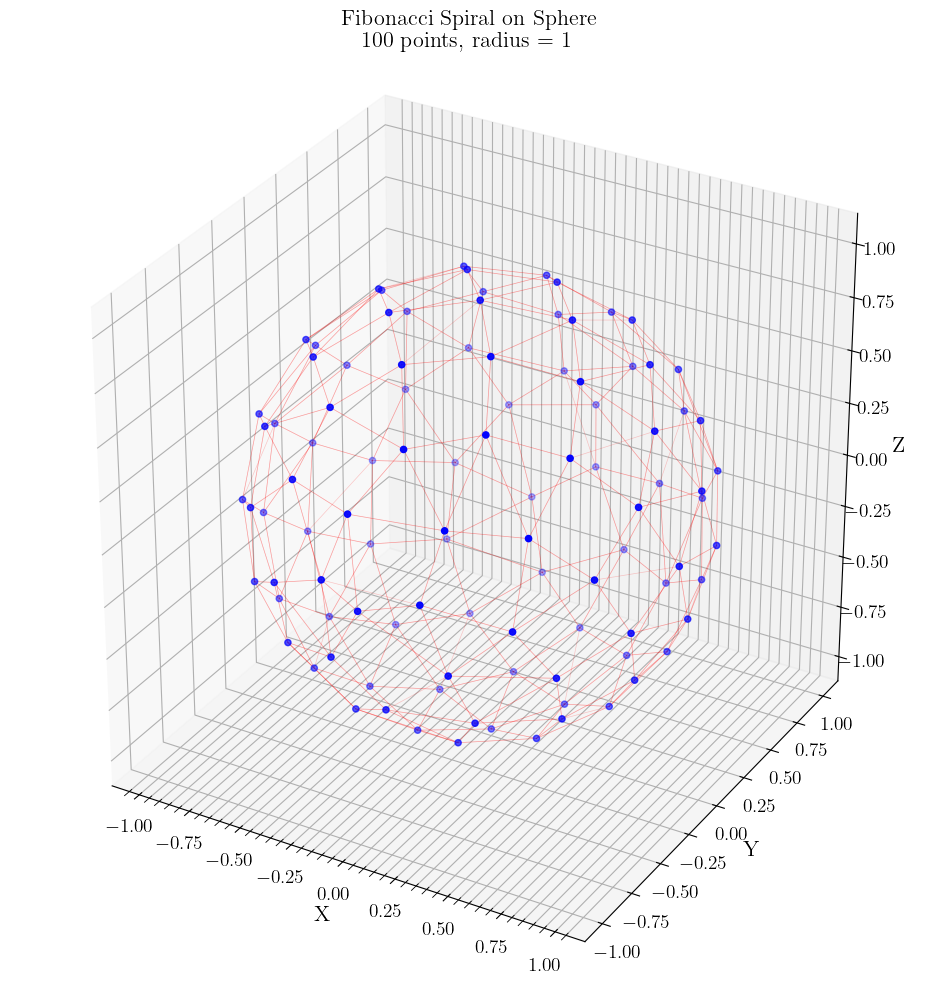

In [4]:
plot_fibonacci_sphere_layer(
    100, radius=1, show_sphere=False, show_lines=True, n_neighbors=5)

### Visualize Fibonacci neutrino halo grid

38.52495133027425 488.4383277344233


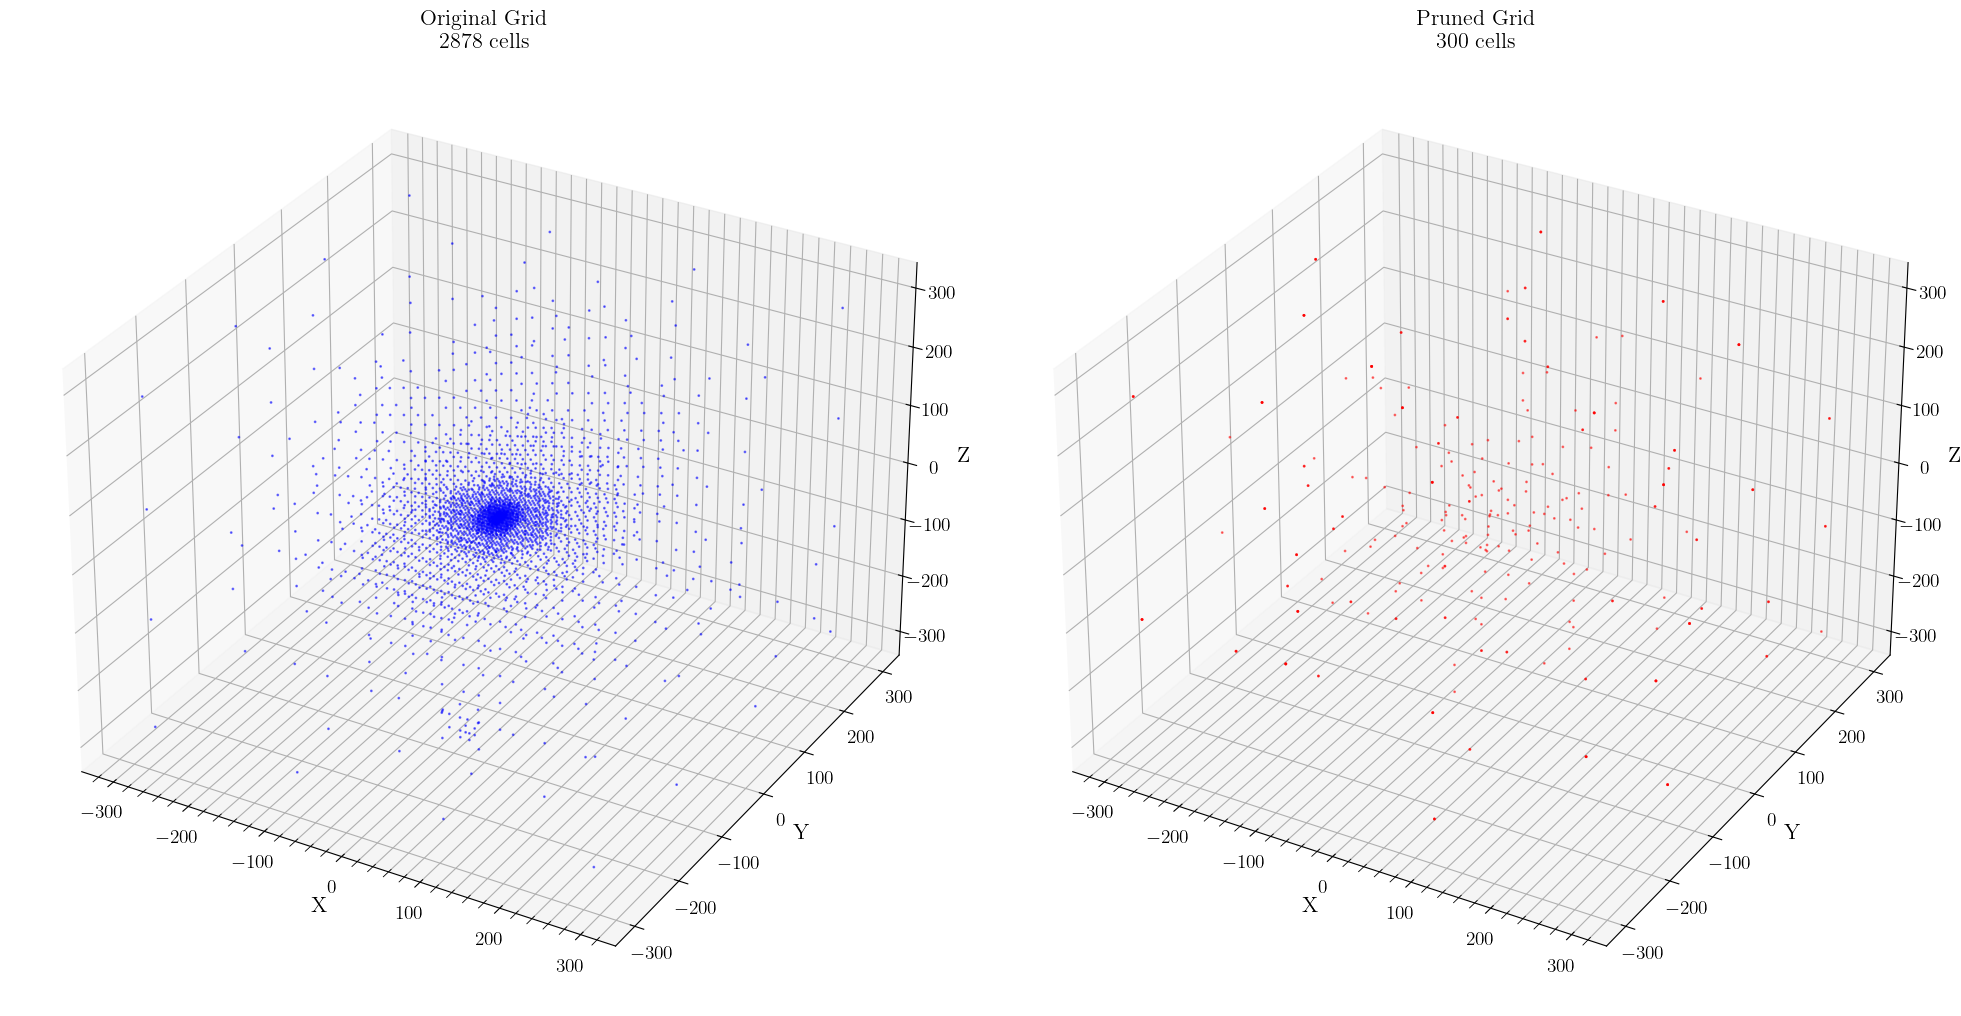

In [40]:
spherical_grid = select_spherical_grid(cell_grid, target_n=300, n_shells=10)

cell_distances = jnp.linalg.norm(spherical_grid, axis=-1)
print(cell_distances.min(), cell_distances.max())

plot_grids(cell_grid, spherical_grid)

## Post-sim analysis

(1, 300, 50)
[ 0 23 33 43]
[53]
(1338, 3)
(300, 3)


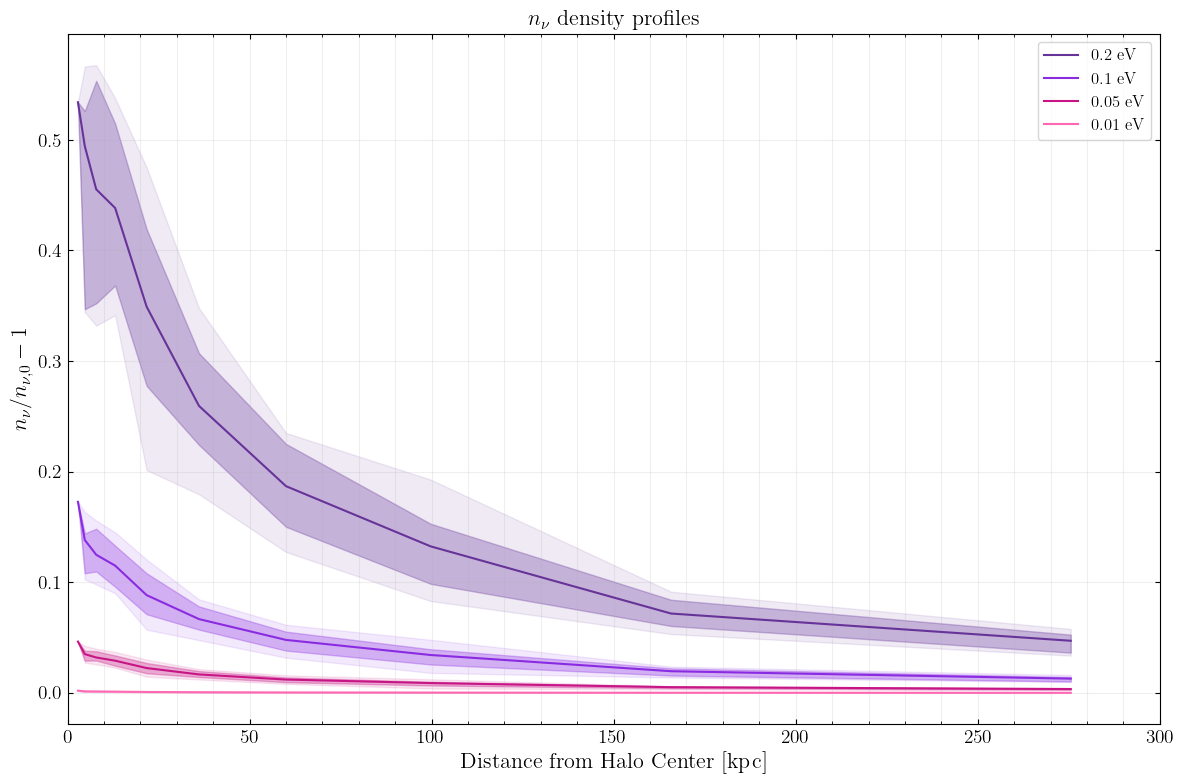

In [59]:
def plot_neutrino_density(
        density_array, spherical_grids, mass_labels=None, num_bins=50):
    """
    Plot neutrino number density vs distance from halo center for different neutrino masses.
    Includes median and percentile bands across multiple halos.
    
    Parameters:
    density_array (np.array): Array of shape (H, C, M) containing neutrino densities.
                              H: number of halos, C: number of cells, M: number of neutrino masses.
    spherical_grids (np.array): Array of shape (H, C, 3) containing x, y, z coordinates of cell centers for each halo.
    mass_labels (list): List of labels for different neutrino masses (optional).
    num_bins (int): Number of distance bins for calculating percentiles.
    """
    # Calculate distances from the halo center for each cell in each halo
    distances = np.linalg.norm(spherical_grids, axis=-1)/Params.kpc
    
    # Create distance bins
    bin_edges = np.logspace(
        np.log10(distances.min()), np.log10(distances.max()), num_bins+1)
    bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # colors = plt.cm.viridis(np.linspace(0, 1, num_masses))[::-1]
    colors = [
        "hotpink", 
        "mediumvioletred", 
        "blueviolet",
        "rebeccapurple",
        # "pink",
    ]

    # Plot for each neutrino mass
    num_masses = density_array.shape[2]
    for m in range(num_masses)[::-1]:
        medians = []
        lower_68 = []
        upper_68 = []
        lower_95 = []
        upper_95 = []
        
        for i in range(num_bins):
            mask = (distances >= bin_edges[i]) & (distances < bin_edges[i+1])
            densities_in_bin = (density_array[mask, m]/Params.N0_cm3)-1
            if densities_in_bin.size > 0:
                medians.append(np.median(densities_in_bin))
                lower_68.append(np.percentile(densities_in_bin, 16))
                upper_68.append(np.percentile(densities_in_bin, 84))
                lower_95.append(np.percentile(densities_in_bin, 2.5))
                upper_95.append(np.percentile(densities_in_bin, 97.5))
            else:
                medians.append(np.nan)
                lower_68.append(np.nan)
                upper_68.append(np.nan)
                lower_95.append(np.nan)
                upper_95.append(np.nan)
        
        label = f"Mass {m+1}" if mass_labels is None else mass_labels[m]
        ax.plot(bin_centers, medians, color=colors[m], label=label)
        ax.fill_between(bin_centers, lower_68, upper_68, color=colors[m], alpha=0.3)
        ax.fill_between(bin_centers, lower_95, upper_95, color=colors[m], alpha=0.1)
    
    ax.set_xlabel("Distance from Halo Center [kpc]")
    ax.set_ylabel(r"$n_\nu / n_{\nu,0} - 1$")
    ax.set_title(r"$n_\nu$ density profiles")
    ax.legend()
    # ax.set_xscale('log')
    # ax.set_yscale('log')
    ax.grid(True, which="both", ls="-", alpha=0.2)
    # ax.set_ylim(1e0, 1e2)
    ax.set_xlim(0, 3e2)

    # Add minor ticks
    # ax.xaxis.set_minor_locator(
    #     plt.LogLocator(base=10, subs=np.arange(1, 10) * 0.1, numticks=10))
    # ax.yaxis.set_minor_locator(
    #     plt.LogLocator(base=10, subs=np.arange(1, 10) * 0.1, numticks=10))
    # ax.tick_params(which='minor', length=4, color='k')
    
    plt.tight_layout()
    plt.show()


print(tot_dens_FD.shape)

m_pick_ids = jnp.argmin(jnp.abs(nu_m_range[:, None] - nu_m_picks[:-1]), axis=0)
print(m_pick_ids)

# tot_dens_FD[..., m_pick_ids]

# Load spherical_grids
halo_indices = jnp.load(f"{sim_folder}/halo_batch_0.6-2.0x1e+12.0_Msun_indices.npy")
print(halo_indices)
original_grids = jnp.squeeze(jnp.load(f"Data/halo_grids/fin_grid_origID{halo_indices[0]}_snap_0036.npy"))
print(original_grids.shape)

# reduced_grids = SimUtil.select_spherical_grid(
#     original_grids, target_n=300, n_shells=10)   

reduced_grids = SimUtil.reduce_cells(original_grids, target_n=300, k_neighbors=len(original_grids))
print(reduced_grids.shape)

mass_labels = ["0.01 eV", "0.05 eV", "0.1 eV", "0.2 eV"]
plot_neutrino_density(
    tot_dens_FD[..., m_pick_ids], reduced_grids[None,...], mass_labels, num_bins=10)